# Pamtra2 tutorial

The following is a walk-through though a Pamtra2 work-flow.

Import all required libraries first

In [1]:
import pamtra2
import collections
import numpy as np
import pandas as pn
import xarray as xr
from collections import OrderedDict
from copy import deepcopy, copy
import toolz
import collections
import matplotlib.pyplot as plt

try:
    %matplotlib inline
except:
    pass

/Users/mmaahn/miniconda3/envs/py36/lib/python3.6/abc.py:133: FutureWarning: xarray subclass customProfile should explicitly define __slots__
  cls = super().__new__(mcls, name, bases, namespace, **kwargs)


# create Pamtra object and Profile object

First we have to create the Pamtra2 object called `pam2`. We have to provide the number of model layers, the frequencies we want to use later, the names of the used hydroometeors (details are defined later) and optionally we can an arbitrary number of additional dimensions, e.g. time, latitude, favorite color, etc.

In [2]:
additionalDims = collections.OrderedDict()
additionalDims['time'] = pn.date_range('2016-01-01','2016-01-05',freq='D')[:1]
additionalDims['lat'] = np.arange(70,80,5)
nHeights = 10

pam2 = pamtra2.pamtra2(
    nLayer=nHeights,
    hydrometeors=['rain','snow'],
    additionalDims = additionalDims,
    frequencies = [35e9, 94e9],
)



The profile data object (it is a xarray DataArray) contains all atmospheric variables. Empty arrays are already provided with the most important variables. You can add additional variables if required.

In [3]:
pam2.profile

<xarray.customProfile>
Dimensions:              (frequency: 2, hydrometeor: 2, lat: 2, layer: 10, time: 1)
Coordinates:
  * time                 (time) datetime64[ns] 2016-01-01
  * lat                  (lat) int64 70 75
  * layer                (layer) int64 0 1 2 3 4 5 6 7 8 9
  * hydrometeor          (hydrometeor) <U4 'rain' 'snow'
  * frequency            (frequency) float64 3.5e+10 9.4e+10
Data variables:
    height               (time, lat, layer) float64 nan nan nan ... nan nan nan
    temperature          (time, lat, layer) float64 nan nan nan ... nan nan nan
    pressure             (time, lat, layer) float64 nan nan nan ... nan nan nan
    relativeHumidity     (time, lat, layer) float64 nan nan nan ... nan nan nan
    horizontalWind       (time, lat, layer) float64 nan nan nan ... nan nan nan
    verticalWind         (time, lat, layer) float64 nan nan nan ... nan nan nan
    eddyDissipationRate  (time, lat, layer) float64 nan nan nan ... nan nan nan
    hydrometeorContent   (time, lat, layer, hydrometeor) float64 nan nan ... nan
    wavelength           (frequency) float64 0.008565 0.003189

Fill the profile with some more or less random variables. The hydrometeorContent field has an additional dimension corresponding to the hydrometeor index.  

In [4]:
pam2.profile.height[:] = np.linspace(10,1000,nHeights)
pam2.profile.temperature[:] = 250 
pam2.profile.relativeHumidity[:] = 90
pam2.profile.pressure[:] = 100000
pam2.profile.eddyDissipationRate[:] = 1e-4
pam2.profile.horizontalWind[:] = 0

pam2.profile.hydrometeorContent.values[:] = 0
#rain
pam2.profile.hydrometeorContent.values[...,5:8,0] = 1e-4
#snow
pam2.profile.hydrometeorContent.values[...,5:8,1] = 2e-4


The `dask` library is for making Pamtra2 parallel: http://dask.pydata.org/ It's use is entirely optional. If used the profile is split up in chunks and each chunk is processed separately. As a little side effect, any calculation is delayed until the result is really needed (e.g. plotting, netcdf export). For testing, dask arrays are turned on by chunking, we keep a version without dask to make the difference clear. 

In [5]:
pam2_nodask = deepcopy(pam2)
pam2.profile = pam2.profile.chunk({'time':1, 'hydrometeor':1, 'lat':1, 'frequency':1})

The helper function `addMissingVariables` calculates missing atmospheric variables like additional humidity measures. Note that because of dask the filed are only created, but the calculation were not done yet. Note the `dask.array<shape=(1, 10, 100), chunksize=(1, 1, 100)>`.



In [6]:
pam2.addMissingVariables()
pam2.profile 

<xarray.customProfile>
Dimensions:              (frequency: 2, hydrometeor: 2, lat: 2, layer: 10, time: 1)
Coordinates:
  * time                 (time) datetime64[ns] 2016-01-01
  * lat                  (lat) int64 70 75
  * layer                (layer) int64 0 1 2 3 4 5 6 7 8 9
  * hydrometeor          (hydrometeor) <U4 'rain' 'snow'
  * frequency            (frequency) float64 3.5e+10 9.4e+10
Data variables:
    height               (time, lat, layer) float64 dask.array<chunksize=(1, 1, 10), meta=np.ndarray>
    temperature          (time, lat, layer) float64 dask.array<chunksize=(1, 1, 10), meta=np.ndarray>
    pressure             (time, lat, layer) float64 dask.array<chunksize=(1, 1, 10), meta=np.ndarray>
    relativeHumidity     (time, lat, layer) float64 dask.array<chunksize=(1, 1, 10), meta=np.ndarray>
    horizontalWind       (time, lat, layer) float64 dask.array<chunksize=(1, 1, 10), meta=np.ndarray>
    verticalWind         (time, lat, layer) float64 dask.array<chunksize=(1, 1, 10), meta=np.ndarray>
    eddyDissipationRate  (time, lat, layer) float64 dask.array<chunksize=(1, 1, 10), meta=np.ndarray>
    hydrometeorContent   (time, lat, layer, hydrometeor) float64 dask.array<chunksize=(1, 1, 10, 1), meta=np.ndarray>
    wavelength           (frequency) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    heightBinDepth       (time, lat, layer) float64 110.0 110.0 ... 110.0 110.0
    specificHumidity     (time, lat, layer) float64 dask.array<chunksize=(1, 1, 10), meta=np.ndarray>
    absoluteHumidity     (time, lat, layer) float64 dask.array<chunksize=(1, 1, 10), meta=np.ndarray>
    dryAirDensity        (time, lat, layer) float64 dask.array<chunksize=(1, 1, 10), meta=np.ndarray>
    airDensity           (time, lat, layer) float64 dask.array<chunksize=(1, 1, 10), meta=np.ndarray>
    dynamicViscosity     (time, lat, layer) float64 dask.array<chunksize=(1, 1, 10), meta=np.ndarray>
    kinematicViscosity   (time, lat, layer) float64 dask.array<chunksize=(1, 1, 10), meta=np.ndarray>
    waterVaporPressure   (time, lat, layer) float64 dask.array<chunksize=(1, 1, 10), meta=np.ndarray>

The nodask version estimates all fields directly, even if they are never used. So we actually get results

In [7]:
pam2_nodask.addMissingVariables()
pam2_nodask.profile 

<xarray.customProfile>
Dimensions:              (frequency: 2, hydrometeor: 2, lat: 2, layer: 10, time: 1)
Coordinates:
  * time                 (time) datetime64[ns] 2016-01-01
  * lat                  (lat) int64 70 75
  * layer                (layer) int64 0 1 2 3 4 5 6 7 8 9
  * hydrometeor          (hydrometeor) <U4 'rain' 'snow'
  * frequency            (frequency) float64 3.5e+10 9.4e+10
Data variables:
    height               (time, lat, layer) float64 10.0 120.0 ... 890.0 1e+03
    temperature          (time, lat, layer) float64 250.0 250.0 ... 250.0 250.0
    pressure             (time, lat, layer) float64 1e+05 1e+05 ... 1e+05 1e+05
    relativeHumidity     (time, lat, layer) float64 90.0 90.0 90.0 ... 90.0 90.0
    horizontalWind       (time, lat, layer) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    verticalWind         (time, lat, layer) float64 nan nan nan ... nan nan nan
    eddyDissipationRate  (time, lat, layer) float64 0.0001 0.0001 ... 0.0001
    hydrometeorContent   (time, lat, layer, hydrometeor) float64 0.0 0.0 ... 0.0
    wavelength           (frequency) float64 0.008565 0.003189
    heightBinDepth       (time, lat, layer) float64 110.0 110.0 ... 110.0 110.0
    specificHumidity     (time, lat, layer) float64 0.0005358 ... 0.0005358
    absoluteHumidity     (time, lat, layer) float64 0.0007464 ... 0.0007464
    dryAirDensity        (time, lat, layer) float64 1.394 1.394 ... 1.394 1.394
    airDensity           (time, lat, layer) float64 1.393 1.393 ... 1.393 1.393
    dynamicViscosity     (time, lat, layer) float64 1.6e-05 1.6e-05 ... 1.6e-05
    kinematicViscosity   (time, lat, layer) float64 1.148e-05 ... 1.148e-05
    waterVaporPressure   (time, lat, layer) float64 86.12 86.12 ... 86.12 86.12

# Describe Hydrometeors
To describe the hydrometeors, you can use functions, xr.DataArrays or scalars. If you provide a function, the function must support xr.DataArrays as input. Of course, the function needs arguments (keywords only!), they are gathered from the following locastions.

1. pam2.hydrometors.name.profile variables (name must match). E.g. density (after it has been calculated) 
2. pam2.profile variables (name must match). E.g. temperature
3. Other provided kwargs (e.g. Dmin, DMax, N0 etc)
4. Default function arguments. Can be turned of with `useFuncArgDefaults = False` to make sure everything is explicitly covered.

The following is for a hydrometeor with a fixed density, e.g. liquid or ice

In [8]:

pam2.addHydrometeor(
    # hydrometeor type
    pamtra2.hydrometeors.softEllipsoidFixedDensity(
        name = 'rain', 
        nBins =40,
        # Boundaries of the size distrbution. linspaceBounds distributes them linearly.
        # Input Dmin, Dmax and nBins is tkane from the other arguments. 
        sizeBounds = pamtra2.hydrometeors.size.linspaceBounds, 
        # center of the size bin where the scattering properties are estimated,
        # boundsToMid takes the numerical center
        sizeCenter = pamtra2.hydrometeors.size.boundsToMid,
        # width of the bins
        sizeBoundsWidth = pamtra2.hydrometeors.size.boundsWidth,
        # size distribution normalized by linear bin width, unit m^-4
        numberConcentration = pamtra2.hydrometeors.numberConcentration.exponentialN0WC, 
        # aspect ratio
        aspectRatio = 1.0,
        # mass, assume an ellipsoid with aspectRatio as defined above.
        mass = pamtra2.hydrometeors.mass.ellipsoid,
        density = pamtra2.hydrometeors.density.water,
        # corss section follows a sphere
        crossSectionArea = pamtra2.hydrometeors.crossSectionArea.sphere,
        # use turner_kneifel_cadeddu to estimtate the relativePermittivity
        relativePermittivity = pamtra2.libs.refractiveIndex.water.turner_kneifel_cadeddu, 
        # use simple Rayleigh scattering
        scattering = pamtra2.hydrometeors.scattering.Rayleigh,
        # define the fall velocity relation. Required variables are tkaen form profiles. 
        fallVelocity = pamtra2.hydrometeors.fallVelocity.khvorostyanov01_drops,
        #mimimum and maximum size. Note this corresponds to sizeBounds
        Dmin  = 1e-6,
        Dmax  = 1e-2,
        # n) is required by exponentialN0WC to make the size distrbution
        N0 =  8e6,
        useFuncArgDefaults = True,
    )
)


/Users/mmaahn/miniconda3/envs/py36/lib/python3.6/site-packages/pamtra2-0.1-py3.6-macosx-10.7-x86_64.egg/pamtra2/hydrometeors/numberConcentration.py:384: UserWarning: Truncation effect on the PSD are not considered. I.e., typically mass is lost!
  warnings.warn('Truncation effect on the PSD are not considered. '
/Users/mmaahn/miniconda3/envs/py36/lib/python3.6/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Did not find information about relativePermittivityIce. This might cause trouble later.


/Users/mmaahn/miniconda3/envs/py36/lib/python3.6/site-packages/pamtra2-0.1-py3.6-macosx-10.7-x86_64.egg/pamtra2/libs/singleScattering/scattering_utilities.py:170: RuntimeWarning: invalid value encountered in double_scalars
  alpha = np.arccos((cos_sca-cos_th*cos_inc)/(sin_th*sin_inc))
/Users/mmaahn/miniconda3/envs/py36/lib/python3.6/site-packages/pamtra2-0.1-py3.6-macosx-10.7-x86_64.egg/pamtra2/libs/singleScattering/scattering_utilities.py:171: RuntimeWarning: invalid value encountered in double_scalars
  beta = np.arccos((cos_inc-cos_th*cos_sca)/(sin_th*sin_sca))
/Users/mmaahn/miniconda3/envs/py36/lib/python3.6/site-packages/pamtra2-0.1-py3.6-macosx-10.7-x86_64.egg/pamtra2/libs/singleScattering/scattering_utilities.py:170: RuntimeWarning: invalid value encountered in double_scalars
  alpha = np.arccos((cos_sca-cos_th*cos_inc)/(sin_th*sin_inc))
/Users/mmaahn/miniconda3/envs/py36/lib/python3.6/site-packages/pamtra2-0.1-py3.6-macosx-10.7-x86_64.egg/pamtra2/libs/singleScattering/scatterin

Note that there is a warning in case not all arguments are used

In [9]:
pam2.addHydrometeor(
    pamtra2.hydrometeors.softEllipsoidMassSize(
        name='snow',
        nBins = 20,
        sizeBounds=pamtra2.hydrometeors.size.logspaceBounds, #function/object to call for getting sizes
        sizeCenter = pamtra2.hydrometeors.size.boundsToMid,
        sizeBoundsWidth = pamtra2.hydrometeors.size.boundsWidth,
        numberConcentration = pamtra2.hydrometeors.numberConcentration.exponentialFieldWC,
        aspectRatio = 0.6,
        crossSectionArea = pamtra2.hydrometeors.crossSectionArea.powerLaw,
        mass = pamtra2.hydrometeors.mass.powerLaw,
        density = pamtra2.hydrometeors.density.softEllipsoid,
        #to do: adapt refractiveIndex routine so that mixing and RI are treated separately. 
        relativePermittivityIce = pamtra2.hydrometeors.relativePermittivity.ice_matzler_2006,
        relativePermittivity = pamtra2.hydrometeors.relativePermittivity.mixing_sihvola,
        scattering = pamtra2.hydrometeors.scattering.Mie,
        fallVelocity = pamtra2.hydrometeors.fallVelocity.heymsfield10_particles,
        Dmin = 1e-6,
        Dmax = 1e-2,
        massSizeA = 0.0121, 
        massSizeB = 1.9,
        areaSizeA = 0.4,
        areaSizeB = 1.8,
        minDensity = 100,
        bla = 12,
        useFuncArgDefaults = True,
        verbosity = 3,
    )
)


/Users/mmaahn/miniconda3/envs/py36/lib/python3.6/site-packages/pamtra2-0.1-py3.6-macosx-10.7-x86_64.egg/pamtra2/hydrometeors/numberConcentration.py:384: UserWarning: Truncation effect on the PSD are not considered. I.e., typically mass is lost!
  warnings.warn('Truncation effect on the PSD are not considered. '
/Users/mmaahn/miniconda3/envs/py36/lib/python3.6/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/mmaahn/miniconda3/envs/py36/lib/python3.6/site-packages/pamtra2-0.1-py3.6-macosx-10.7-x86_64.egg/pamtra2/hydrometeors/core.py:286: UserWarning: The following kwargs were NOT used: ['bla', 'verbosity']
  '%s' % self._keysToBeUsed)
/Users/mmaahn/miniconda3/envs/py36/lib/python3.6/site-packages/pamtra2-0.1-py3.6-macosx-10.7-x86_64.egg/pamtra2/libs/singleScattering/scattering_utilities.py:170: RuntimeWarning: invalid value encountered in double_scalars
  alpha = np.arccos((cos_sca-cos

We have access to a lot of internal properties, like the fall velocityu of particles

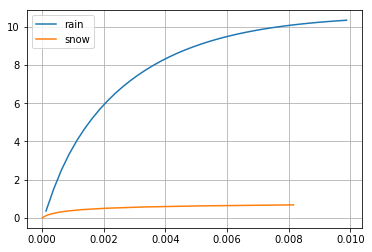

In [10]:
plt.plot(
    pam2.hydrometeors.rain.profile.sizeCenter,
    pam2.hydrometeors.rain.profile.fallVelocity.isel(layer=1,time=0,lat=0),
    label = 'rain')
plt.plot(
    pam2.hydrometeors.snow.profile.sizeCenter,
    pam2.hydrometeors.snow.profile.fallVelocity.isel(layer=1,time=0,lat=0),
    label = 'snow')
plt.legend()
plt.grid()


Force computation with e.g.
`pam2.hydrometeors.rain.profile.compute()` or `pam2.hydrometeors.rain.profile.to_netcdf()` or  or `pam2.hydrometeors.rain.profile.fallVelocity.plot()`

# Radar simulator


In [11]:


pam2.addInstrument(
    pamtra2.instruments.radar.dopplerRadarPamtra(
        name = 'test',
        frequencies = [3.5e+10],    
        radarMaxV=7.885,
        radarMinV=-7.885,
        radarAliasingNyquistInterv=10,
        radarNFFT=256,
        verbosity=0,
        radarAirmotion=True,
        radarAirmotionModel="constant",  # "constant","linear","step"
        radarAirmotionVmin=0,
        radarAirmotionVmax=0,
        radarAirmotionLinearSteps=30,
        radarAirmotionStepVmin=0.5,
        radarK2=0.93,         # dielectric constant |K|² (always for liquid water by convention) for the radar equation
        radarBeamwidthDeg=0.2,
        radarIntegrationTime=60,
        radarPNoise1000=-30,
        radarNAve=150,
        seed=0,
    ),
    solve=False,
)

In [12]:
pam2.instruments.test.solve()

<xarray.Dataset>
Dimensions:                    (dopplerVelocity: 256, dopplerVelocityAliased: 5376, frequency: 1, lat: 2, layer: 10, peak: 2, time: 1)
Coordinates:
  * frequency                  (frequency) float64 3.5e+10
  * lat                        (lat) int64 70 75
  * time                       (time) datetime64[ns] 2016-01-01
  * layer                      (layer) int64 0 1 2 3 4 5 6 7 8 9
  * dopplerVelocity            (dopplerVelocity) float64 -7.885 -7.823 ... 7.823
  * peak                       (peak) int64 1 2
Dimensions without coordinates: dopplerVelocityAliased
Data variables:
    specificAttenuation        (frequency, time, lat, layer) float64 dask.array<chunksize=(1, 1, 1, 10), meta=np.ndarray>
    pathIntegratedAttBottomUp  (frequency, time, lat, layer) float64 dask.array<chunksize=(1, 1, 1, 10), meta=np.ndarray>
    pathIntegratedAttTopDown   (frequency, time, lat, layer) float64 dask.array<chunksize=(1, 1, 1, 10), meta=np.ndarray>
    radarIdealizedSpectrum     (dopplerVelocityAliased, time, lat, layer, frequency) float64 dask.array<chunksize=(5376, 1, 1, 10, 1), meta=np.ndarray>
    radarSpectrum              (dopplerVelocity, time, lat, layer, frequency) float64 dask.array<chunksize=(256, 1, 1, 10, 1), meta=np.ndarray>
    radarReflectivity          (peak, time, lat, layer, frequency) float64 dask.array<chunksize=(2, 1, 1, 10, 1), meta=np.ndarray>
    meanDopplerVel             (peak, time, lat, layer, frequency) float64 dask.array<chunksize=(2, 1, 1, 10, 1), meta=np.ndarray>
    spectrumWidth              (peak, time, lat, layer, frequency) float64 dask.array<chunksize=(2, 1, 1, 10, 1), meta=np.ndarray>
    skewness                   (peak, time, lat, layer, frequency) float64 dask.array<chunksize=(2, 1, 1, 10, 1), meta=np.ndarray>
    kurtosis                   (peak, time, lat, layer, frequency) float64 dask.array<chunksize=(2, 1, 1, 10, 1), meta=np.ndarray>
    leftSlope                  (peak, time, lat, layer, frequency) float64 dask.array<chunksize=(2, 1, 1, 10, 1), meta=np.ndarray>
    rightSlope                 (peak, time, lat, layer, frequency) float64 dask.array<chunksize=(2, 1, 1, 10, 1), meta=np.ndarray>
    leftEdge                   (peak, time, lat, layer, frequency) float64 dask.array<chunksize=(2, 1, 1, 10, 1), meta=np.ndarray>
    rightEdge                  (peak, time, lat, layer, frequency) float64 dask.array<chunksize=(2, 1, 1, 10, 1), meta=np.ndarray>
    quality                    (time, lat, layer, frequency) float64 dask.array<chunksize=(1, 1, 10, 1), meta=np.ndarray>
    noiseMean                  (time, lat, layer, frequency) float64 dask.array<chunksize=(1, 1, 10, 1), meta=np.ndarray>

Again, the results are not estimated yet when using dask.

In [13]:
pam2.instruments.test.results


<xarray.Dataset>
Dimensions:                    (dopplerVelocity: 256, dopplerVelocityAliased: 5376, frequency: 1, lat: 2, layer: 10, peak: 2, time: 1)
Coordinates:
  * frequency                  (frequency) float64 3.5e+10
  * lat                        (lat) int64 70 75
  * time                       (time) datetime64[ns] 2016-01-01
  * layer                      (layer) int64 0 1 2 3 4 5 6 7 8 9
  * dopplerVelocity            (dopplerVelocity) float64 -7.885 -7.823 ... 7.823
  * peak                       (peak) int64 1 2
Dimensions without coordinates: dopplerVelocityAliased
Data variables:
    specificAttenuation        (frequency, time, lat, layer) float64 dask.array<chunksize=(1, 1, 1, 10), meta=np.ndarray>
    pathIntegratedAttBottomUp  (frequency, time, lat, layer) float64 dask.array<chunksize=(1, 1, 1, 10), meta=np.ndarray>
    pathIntegratedAttTopDown   (frequency, time, lat, layer) float64 dask.array<chunksize=(1, 1, 1, 10), meta=np.ndarray>
    radarIdealizedSpectrum     (dopplerVelocityAliased, time, lat, layer, frequency) float64 dask.array<chunksize=(5376, 1, 1, 10, 1), meta=np.ndarray>
    radarSpectrum              (dopplerVelocity, time, lat, layer, frequency) float64 dask.array<chunksize=(256, 1, 1, 10, 1), meta=np.ndarray>
    radarReflectivity          (peak, time, lat, layer, frequency) float64 dask.array<chunksize=(2, 1, 1, 10, 1), meta=np.ndarray>
    meanDopplerVel             (peak, time, lat, layer, frequency) float64 dask.array<chunksize=(2, 1, 1, 10, 1), meta=np.ndarray>
    spectrumWidth              (peak, time, lat, layer, frequency) float64 dask.array<chunksize=(2, 1, 1, 10, 1), meta=np.ndarray>
    skewness                   (peak, time, lat, layer, frequency) float64 dask.array<chunksize=(2, 1, 1, 10, 1), meta=np.ndarray>
    kurtosis                   (peak, time, lat, layer, frequency) float64 dask.array<chunksize=(2, 1, 1, 10, 1), meta=np.ndarray>
    leftSlope                  (peak, time, lat, layer, frequency) float64 dask.array<chunksize=(2, 1, 1, 10, 1), meta=np.ndarray>
    rightSlope                 (peak, time, lat, layer, frequency) float64 dask.array<chunksize=(2, 1, 1, 10, 1), meta=np.ndarray>
    leftEdge                   (peak, time, lat, layer, frequency) float64 dask.array<chunksize=(2, 1, 1, 10, 1), meta=np.ndarray>
    rightEdge                  (peak, time, lat, layer, frequency) float64 dask.array<chunksize=(2, 1, 1, 10, 1), meta=np.ndarray>
    quality                    (time, lat, layer, frequency) float64 dask.array<chunksize=(1, 1, 10, 1), meta=np.ndarray>
    noiseMean                  (time, lat, layer, frequency) float64 dask.array<chunksize=(1, 1, 10, 1), meta=np.ndarray>

Do the numbers!

In [14]:
pam2.instruments.test.results.load()

/Users/mmaahn/miniconda3/envs/py36/lib/python3.6/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/mmaahn/miniconda3/envs/py36/lib/python3.6/site-packages/pamtra2-0.1-py3.6-macosx-10.7-x86_64.egg/pamtra2/libs/singleScattering/scattering_utilities.py:170: RuntimeWarning: invalid value encountered in double_scalars
  alpha = np.arccos((cos_sca-cos_th*cos_inc)/(sin_th*sin_inc))
/Users/mmaahn/miniconda3/envs/py36/lib/python3.6/site-packages/pamtra2-0.1-py3.6-macosx-10.7-x86_64.egg/pamtra2/libs/singleScattering/scattering_utilities.py:171: RuntimeWarning: invalid value encountered in double_scalars
  beta = np.arccos((cos_inc-cos_th*cos_sca)/(sin_th*sin_sca))


<xarray.Dataset>
Dimensions:                    (dopplerVelocity: 256, dopplerVelocityAliased: 5376, frequency: 1, lat: 2, layer: 10, peak: 2, time: 1)
Coordinates:
  * frequency                  (frequency) float64 3.5e+10
  * lat                        (lat) int64 70 75
  * time                       (time) datetime64[ns] 2016-01-01
  * layer                      (layer) int64 0 1 2 3 4 5 6 7 8 9
  * dopplerVelocity            (dopplerVelocity) float64 -7.885 -7.823 ... 7.823
  * peak                       (peak) int64 1 2
Dimensions without coordinates: dopplerVelocityAliased
Data variables:
    specificAttenuation        (frequency, time, lat, layer) float64 5.399e-05 ... 5.399e-05
    pathIntegratedAttBottomUp  (frequency, time, lat, layer) float64 0.005939 ... 0.2554
    pathIntegratedAttTopDown   (frequency, time, lat, layer) float64 0.2554 ... 0.005939
    radarIdealizedSpectrum     (dopplerVelocityAliased, time, lat, layer, frequency) float64 0.0 ... 0.0
    radarSpectrum              (dopplerVelocity, time, lat, layer, frequency) float64 5.72e-09 ... 6.036e-05
    radarReflectivity          (peak, time, lat, layer, frequency) float64 nan ... nan
    meanDopplerVel             (peak, time, lat, layer, frequency) float64 nan ... nan
    spectrumWidth              (peak, time, lat, layer, frequency) float64 nan ... nan
    skewness                   (peak, time, lat, layer, frequency) float64 nan ... nan
    kurtosis                   (peak, time, lat, layer, frequency) float64 nan ... nan
    leftSlope                  (peak, time, lat, layer, frequency) float64 nan ... nan
    rightSlope                 (peak, time, lat, layer, frequency) float64 nan ... nan
    leftEdge                   (peak, time, lat, layer, frequency) float64 nan ... nan
    rightEdge                  (peak, time, lat, layer, frequency) float64 nan ... nan
    quality                    (time, lat, layer, frequency) float64 64.0 ... 64.0
    noiseMean                  (time, lat, layer, frequency) float64 -70.03 ... -30.0

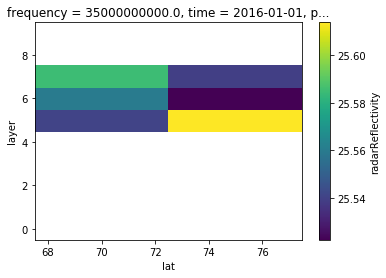

In [15]:
pam2.instruments.test.results.radarReflectivity.isel(peak=0,time=0).T.plot()